# Initial Test Data Analysis
See [This GitLAB Issue](https://code.crearecomputing.com/hearingproducts/open-hearing-group/open-hearing-hardware/-/issues/1) for details ont he data collection. 

In this notebook:

0. Load Common Data Structure (Setup)
1. Speaker calibration
2. Mic amplitude calibrations
3. Mic phase calibrations

# 0. Load Common Data Structures

In [1]:
%matplotlib inline

## Imports

In [2]:
# Import dependencies
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage, optimize, interpolate

from owai.core import io
from owai.core import signal_processing_utils as spu
from owai.core.model import StraightTube
from owai.core.units import units

## Helper utillity functions

In [3]:
def get_meta_value_units(section, *keys):
    """ REquires test_meta and units to be global variables"""
    section = test_meta[section]
    root = section
    for key in keys:
        root = root.get(key)
    return root["value"] * units(root["units"])

def get_ptheory(f, x, model, **kwargs):
    for k, v in kwargs.items():
        setattr(model, k, v)
    return model.p(f, x)

def todB(a):
    return 20 * np.log10(np.abs(a) / 20e-6)

## File Paths and Metadata Loading

In [4]:
# Figure style and line style
figkwargs = dict(figsize=(6.5, 6.5 / 1.618034), dpi=90)
linekwargs = dict(lw=1, alpha=0.5)

# Set up path to the data
data_folder = "2024-07-01_AurenV1_calibration-data-collection"
path = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "Testing", "Data", data_folder)  # From windows
if os.environ.get("OLYMPUS_PROJECTS_PATH", False):
    path = path.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
print("Looking for data in this path:", path)

path_meta = os.path.join(path, 'testdata.yaml')
print("Looking for test meta data in this path:", path_meta)

# Load test metadata
test_meta = io.load_test_data(path_meta)
# pprint(test_meta)

# Set constants
speed_of_sound = 343 * units.m / units.s
n_channels = 4

# probe geometry
length_probe = get_meta_value_units("probe_geometry", "length")
length_tests = [length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "length") for i in range(4)]
x_probe = [
    length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "x_of_probe")
    for i in range(4)
    ]
x_mic = get_meta_value_units('probe_geometry', 'mic_positions')

# Dictionary to hold the calibration data
calibration_data = {"RL": 0.999, "R0": 0.999}  # We will store the calibration data here

Looking for data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection
Looking for test meta data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection/testdata.yaml


## Data loading

In [5]:
test_keys = [
    'cavern_1_B&K_in_probe_port',
    'cavern_2_B&K_in_probe_port',
    'cavern_3_B&K_in_probe_port',
    'cavern_4_B&K_in_probe_port',
    ]

# make sure all the data has the same shape
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]
data_slice = slice(
    int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
    int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate), None)

times = {}
data = {}
times_ref = {}
data_ref = {}
for i, test_key in enumerate(test_keys):
    cavern_times = []
    cavern_data = []
    cavern_times_ref = []
    cavern_data_ref = []
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times.append(t[data_slice])
        cavern_data.append(d[data_slice].T)
        if len(tests) == 1:
            continue
        fn = os.path.join(path, tests[1])
        t, d, samplerate_bk = io.load_wav(fn)
        slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
        cavern_times_ref.append(t[slc])
        cavern_data_ref.append(d[slc].T)
    times[test_key] = cavern_times
    data[test_key] = cavern_data
    times_ref[test_key] = cavern_times_ref
    data_ref[test_key] = cavern_data_ref
# Done reading all the data

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection/BKProbe_003.dat
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01

## Fourier Transforms and Data Wrangling

In [6]:
# Use last two tests
f_ref = []
p_ref = []
p = []
f = []
for key in test_keys:
    this_p_ref = []
    this_f_ref = []
    this_p = []
    this_f = []
    for test in [-2, -1]:
        my_f, my_p = spu.to_fourier(data[key][test], samplerate)
        keep_inds = (my_f >= 100) & (my_f < 20000)
        my_f = my_f[keep_inds]
        my_p = my_p[:, keep_inds]
        this_p.append(my_p)
        this_f.append(my_f)
        if not data_ref[key]:
            continue
        my_f_ref, my_p_ref = spu.to_fourier(data_ref[key][test], samplerate_bk)
        keep_inds = (my_f_ref >= 100) & (my_f_ref < 20000)
        my_f_ref = my_f_ref[keep_inds]
        my_p_ref = my_p_ref[keep_inds]
        this_p_ref.append(my_p_ref)
        this_f_ref.append(my_f_ref)

    this_p = np.stack(this_p, axis=0)
    this_f = np.stack(this_f, axis=0)
    p.append(this_p)
    f.append(this_f)
    if not this_p_ref:
        continue
    this_p_ref = np.stack(this_p_ref, axis=0)
    this_f_ref = np.stack(this_f_ref, axis=0)
    p_ref.append(this_p_ref)
    f_ref.append(this_f_ref)
p = np.stack(p, axis=0)
f = np.stack(f, axis=0)
p_ref = np.stack(p_ref, axis=0)
f_ref = np.stack(f_ref, axis=0)
axis_order = ['test_geometry', 'test_iteration', "channel", 'data']

In [7]:
R0 = calibration_data["R0"]
RL = calibration_data["RL"]
cavern_model = StraightTube(L=0, R0=R0, RL=RL, P0=1.0, PL=0.0)

# First, we need to try an align the theory with the measurements

In [8]:
20 * np.log10(np.abs(p_ref) / 20e-6).max()  # Scaling looks pretty good

56.0223571738338

### Plots

Cavern 0, Trial 0, Magdiff 0.019325255114474537
Cavern 0, Trial 1, Magdiff 0.3007256235866677
Cavern 1, Trial 0, Magdiff 0.018546543140250588
Cavern 1, Trial 1, Magdiff 0.018557830900817834
Cavern 2, Trial 0, Magdiff 0.01858697146192767
Cavern 2, Trial 1, Magdiff 0.018634684846235844
Cavern 3, Trial 0, Magdiff 0.020130735651715914
Cavern 3, Trial 1, Magdiff 0.020142959354646772


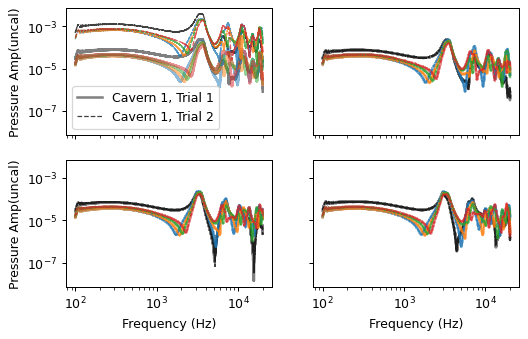

In [9]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
ref_channel = 3
lines = ['-', '--']
for i in range(4):
    ii = i // 2
    jj = i % 2
    for j in range(2):
        magdiff = np.abs(p[i, j, ref_channel, :]).mean() / np.abs(p_ref[i, j, :]).mean()
        axs[ii,jj].loglog(f_ref[i, j], np.abs(p_ref[i, j, :]) * magdiff, 'k' + lines[j], label="Cavern {}, Trial {}".format(i+1,j+1), lw=2-j, alpha=0.5 + 0.25 * j)
        if i == 0: axs[ii,jj].legend()
        print ("Cavern {}, Trial {}, Magdiff {}".format(i, j, magdiff))
    for j in range(2):
        axs[ii,jj].set_prop_cycle(None)
        axs[ii,jj].loglog(f[i, j], np.abs(p[i, j, :, :]).T, lines[j], label="Trial {}".format(j + 1), lw=2-j, alpha=0.5 + 0.25 * j)
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Pressure Amp(uncal)')
axs[-1, 0].set_ylabel('Pressure Amp(uncal)')
plt.show()

# Calibration

In [10]:
p_ref_on_f = np.array([[np.interp(f[i, j], f_ref[i, j], np.abs(p_ref[i, j])) for j in range(p_ref.shape[1])] for i in range(p_ref.shape[0])])

In [11]:
# cavern_model.absorption_loss = 0.4
# cavern_model.absorption_loss = 0.2
# cavern_model.absorption_loss = 0.1
# cavern_model.absorption_loss = 0.05
# cavern_model.absorption_loss = 0.005
# cavern_model.absorption_loss = 0.01
# cavern_model.absorption_loss = 0.08
# cavern_model.absorption_loss = 0.04
cavern_model.absorption_loss = 0.0

To solve for the calibrations, we use the following set of equations for EACH cavern:
\begin{align}
    A_0 e^{-ijkL_0} + B_0 e^{ijkL_0} - p_0 p_{cal,0} &=0\\
    A_0 e^{-ijkL_1} + B_0 e^{ijkL_1} - p_1 p_{cal,1}  &=0\\
    A_0 e^{-ijkL_{ref}} + B_0 e^{ijkL_{ref}} = p_{ref} \\
\end{align}

As a matrix, that looks like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} &      e^{ijkL_0}     & -p_0  & 0 \\
        e^{-ijkL_1} &      e^{ijkL_1}     &  0    &-p_1\\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0
    \end{bmatrix}
    \begin{bmatrix}
        A_0 \\
        B_0 \\
        p_{cal,0} \\
        p_{cal,1}
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        p_{ref} 
    \end{bmatrix}
\end{gather}

We don't have enough equations (3 equations, 4 unknowns), so we have to add additional caverns... then it becomes like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} & e^{ijkL_0} & 0 & 0 & -p_0  & 0 \\
        e^{-ijkL_1} & e^{ijkL_1} & 0 & 0 & 0 & -p_1\\
        0 & 0 & e^{-ijkL_0} & e^{ijkL_0} & -p_0  & 0 \\
        0 & 0 & e^{-ijkL_1} & e^{ijkL_1} &  0    &-p_1\\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0 & 0 & 0 \\
        0& 0 & e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0  \\
    \end{bmatrix}
    \begin{bmatrix}
        A_{0} \\
        B_{0} \\
        A_{1} \\
        B_{1} \\
        p_{cal,0} \\
        p_{cal,1}
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
        p_{ref, 0} \\
        p_{ref, 1} 
    \end{bmatrix}
\end{gather}

But ultimately, we only care about the last two unknowns in x. 




In [12]:
channels = [0, 1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
# channels = [1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
n_channels = len(channels)
n_caverns = 4
trial_number = 0
x = x_mic[channels].to('m').magnitude
# x[2] -= 0.002 # See what an offset does
# x[0] += 0.002 # See what an offset does

k = cavern_model.k(f[0, 0]).magnitude
A = np.zeros((p.shape[-1], n_channels * n_caverns, 2 * n_caverns + n_channels-1), dtype=np.complex128)
b = np.zeros((p.shape[-1], n_channels * n_caverns), dtype=np.complex128)
for j in range(n_caverns):
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 0] = np.exp(-1j * k[:, None] * x[None, :])
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 1] = np.exp( 1j * k[:, None] * x[None, :])
    for i in range(n_channels - 1):
        A[:, j*n_channels + i, -n_channels + 1 + i] = -p[j, trial_number, channels[i]]
        # A[:, j*n_channels + 1, -1] = -p[j, 0, channels[1]]
    b[:, j*n_channels + n_channels - 1] = p[j, 0, channels[-1]]

Ainv = np.linalg.pinv(A)
cal = np.einsum('ijk,ik->ij', Ainv, b)

In [13]:
# Re-arrange the calibration function so that it goes channel 0, channel 1, ... etc. 
# The first of these is not actually a calibration, we'll use it for the reference channel
cal_ordered = np.empty((p.shape[-1], p.shape[-2]), cal.dtype)
cal_ordered.fill(1)
# Set reference channel calibration to all 1's
cal_ordered[:, channels[-1]] = 1
# Collect channel calibration data
cal_ordered[:, channels[:-1]] = cal[:, -n_channels + 1:]

In [14]:
s_phase = 0.01
s_amp = 0.0025

# s_phase = 0.1
# s_amp = 0.025

s_phase = 0.0025
s_amp = 0.0025

s_phase = 0.0025
s_amp = 0.25


cal_phase = [interpolate.splrep(
    (f[0, 0]), np.angle(cal_ordered[:, i]),w=np.sqrt(f[0, 0] / f[0, 0].max()),
    s=s_phase*f.shape[-1]) for i in range(p.shape[-2])]
cal_amp = [interpolate.splrep(
    np.log10(f[0, 0]), np.log10(np.abs(cal_ordered[:, i])), #w=1/f[0, 0],
    s=s_amp*f.shape[-1]) for i in range(p.shape[-2])]
cal_phase = np.stack([interpolate.splev((f[0, 0]), cal_phase[i]) for i in range(p.shape[-2])], axis=0)
cal_amp = np.stack([10**interpolate.splev(np.log10(f[0, 0]), cal_amp[i]) for i in range(p.shape[-2])], axis=0)
cal2 = (cal_amp * np.exp(1j*cal_phase)).T

(-18.0, 18.0)

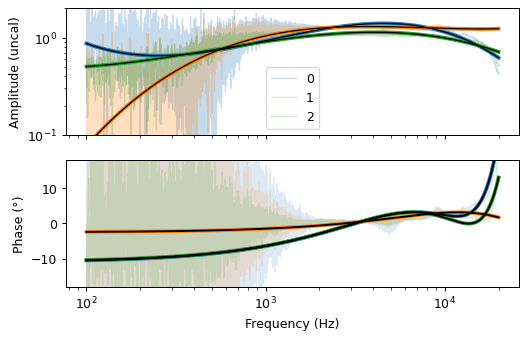

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(cal_ordered[:, :-1]), lw=1, alpha=0.25)
axs[0].legend(range(3))
axs[0].set_prop_cycle(None)
axs[0].loglog(f[0, 0], np.abs(cal2[:, :-1]), lw=3)
axs[0].loglog(f[0, 0], cal_amp[:-1].T, 'k', lw=1)
axs[0].set_ylabel("Amplitude (uncal)")
axs[0].set_ylim([0.1, 2])
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal_ordered[:, :-1])), lw=1, alpha=0.15)
axs[1].set_prop_cycle(None)
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal2[:, :-1])), lw=3)
axs[1].semilogx(f[0, 0], np.rad2deg(cal_phase[:-1].T),'k')
axs[1].set_ylabel('Phase (°)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylim([-18, 18])

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Text(0.5, 0, 'Frequency (Hz)')

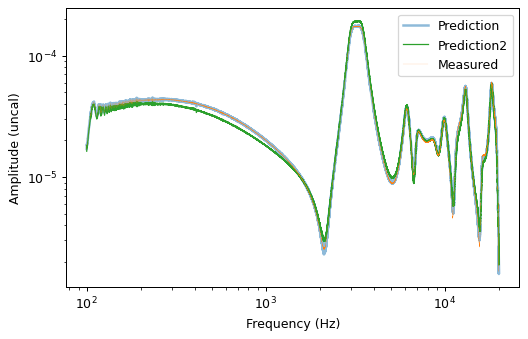

In [16]:
mic1 = 1
mic2 = 2
mic_ref = 3
channel = 3
trial = 1
p3_pred = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_mic[mic_ref],
    x_mic[mic1], x_mic[mic2],
    p[channel, trial, mic1] * cal_ordered[:, mic1], p[channel, trial, mic2] * cal_ordered[:, mic2])
p3_pred_smooth = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_mic[mic_ref],
    x_mic[mic1], x_mic[mic2],
    p[channel, trial, mic1] * cal2[:, mic1], p[channel, trial, mic2] * cal2[:, mic2])

fig, axs = plt.subplots(1, 1, sharex=True, **figkwargs)
axs.loglog(f[0, 0], np.abs(p3_pred), 'C0', lw=2, alpha=0.5, label="Prediction")
axs.loglog(f[0, 0], np.abs(p3_pred_smooth), 'C2', lw=1, label="Prediction2")
axs.loglog(f[0, 0], np.abs(p[channel, trial, mic_ref]), 'C1', lw=0.1, label="Measured")
axs.legend()
axs.set_ylabel("Amplitude (uncal)")
axs.set_xlabel('Frequency (Hz)')

In [17]:
# Now, calibrate the amplitude using a VERY similar approach to older attempts, but using the B&K probe measured pressure
x_probe_offset = 0* units.mm
mic_ref = channels[-1]
trial = 0

# NOTE :We can get more examples of amp_cal by using a different mic with the final mic (3 rounds in total)
# TODO: USE ALL available MICs in the Calibration. 
mic_p_correction = np.ones((len(channels)-1, p.shape[0], p.shape[-1]))
for i, mic in enumerate(channels[:-1]): 
    p_probe_pred = cavern_model.p_measured(
        f[0, 0] * units.Hz,
        x_probe[0] + x_probe_offset,
        x_mic[mic], x_mic[mic_ref],
        p[:, trial, mic] * cal2[:, mic], p[:, trial, mic_ref])
    # mic_p_correction[i] = np.abs(p_probe_pred)
    mic_p_correction[i] = np.abs(p_ref_on_f[:, trial] / p_probe_pred)

# s_abs_amp = 0.5
s_abs_amp = 2

amp_cal = mic_p_correction.mean(axis=(0, 1))
amp_cal_b = 10**(np.log10(mic_p_correction).mean(axis=(0, 1)))
amp_cal_orig = mic_p_correction.mean(axis=(0, 1))
# TODO, make a better fit with ALL the data here, not just a mean of the data...
# f_exp = f[:amp_cal.shape[1], trial][None].repeat(amp_cal.shape[0], axis=0) 
f_exp = f[0,0] 
# f_exp = f_exp + np.random.randn(*f_exp.shape)
I = np.argsort(f_exp.ravel(order="F"))

# Logarithm version
amp_cal_spline = interpolate.splrep(
    np.log10(f_exp).ravel(order="F")[I],
    np.log10(np.abs(amp_cal)).ravel(order="F")[I], w=1 / (f_exp.ravel(order="F") / f.max())[I],
    s=s_abs_amp*f.shape[-1])
amp_cal2 = 10**interpolate.splev(np.log10(f[0, 0]), amp_cal_spline)

# Non-logarithm version
# amp_cal_spline = interpolate.splrep(
#     (f_exp).ravel(order="F")[I],
#     np.log10(np.abs(amp_cal)).ravel(order="F")[I], w=1 / (f_exp.ravel(order="F") / f.max())[I],
#     s=s_abs_amp*f.shape[-1])
# amp_cal2 = 10**interpolate.splev((f[0, 0]), amp_cal_spline)


/tmp/ipykernel_27773/2680859057.py:16: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  mic_p_correction[i] = np.abs(p_ref_on_f[:, trial] / p_probe_pred)


In [18]:
# plt.figure(**figkwargs)
# plt.loglog(f[0, 0], mic_p_correction[0].T, lw=0.1, alpha=1)
# plt.loglog(f[0, 0], mic_p_correction[1].T, lw=0.2, alpha=0.5)
# plt.loglog(f[0, 0], mic_p_correction[2].T, lw=0.3, alpha=0.25)
# # plt.loglog(f[0, 0], amp_cal_orig, 'k', alpha=0.5, lw=0.2)
# # plt.loglog(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
# # plt.loglog(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)
# plt.legend(range(8))

In [19]:
# # plt.plot(np.log10(f_exp).ravel(order="F"), np.log10(np.abs(amp_cal)).ravel(order="F"))
# plt.plot(np.log10(f_exp).ravel(order="F"), 1 / (f_exp.ravel(order="F") / f.max()))

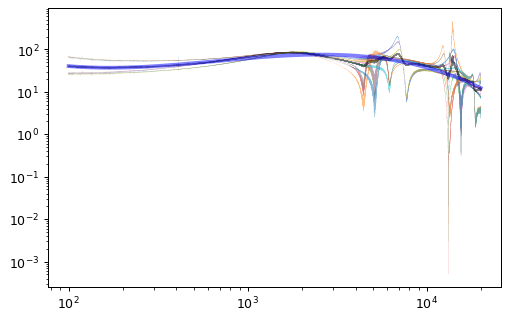

In [20]:
plt.figure(**figkwargs)
plt.loglog(f[0, 0], mic_p_correction.reshape(np.prod(mic_p_correction.shape[:2]), -1).T, lw=0.1, alpha=0.5)
plt.loglog(f[0, 0], amp_cal_orig, 'k', alpha=0.5, lw=1)
# plt.loglog(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
plt.loglog(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)
# plt.legend(range(12))

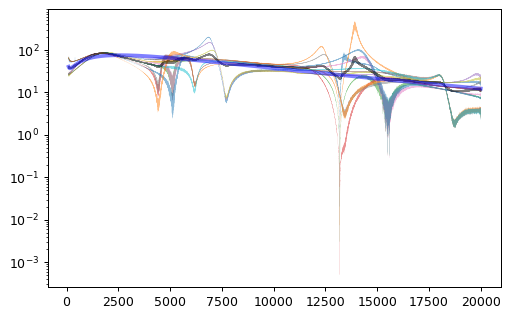

In [21]:
plt.figure(**figkwargs)
plt.semilogy(f[0, 0], mic_p_correction.reshape(np.prod(mic_p_correction.shape[:2]), -1).T, lw=0.1, alpha=0.5)
plt.semilogy(f[0, 0], amp_cal, 'k', alpha=0.5, lw=1)
# plt.semilogy(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
plt.semilogy(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)

In [22]:
amp_cal = amp_cal2
# amp_cal = 10**np.log10(np.abs(amp_cal_orig)).mean(0)

In [23]:
# channel = 3
# mic1 = 1
# N = p_ref.shape[0]
# p_probe_pred2 = cavern_model.p_measured(
#     f[0, 0] * units.Hz,
#     x_probe[0] + x_probe_offset,
#     x_mic[mic1], x_mic[mic_ref],
#     p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

# mic1 = 2
# p_probe_pred22 = cavern_model.p_measured(
#     f[0, 0] * units.Hz, 
#     x_probe[0] + x_probe_offset,
#     x_mic[mic1], x_mic[mic_ref],
#     p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

# plt.figure(**figkwargs)
# plt.loglog(f_ref[0, 0], np.abs(p_probe_pred2[channel]).T, 'C0', alpha=0.9, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], np.abs(p_probe_pred22[channel]).T, 'C1', alpha=0.5, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], np.abs( p_ref[channel, trial]), 'k', alpha=0.5, label="Reference", lw=0.5)
# plt.legend()
# plt.figure(**figkwargs)
# plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 1]) * cal2[:, 1]).T * amp_cal, 'C0', alpha=0.9, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 2]) * cal2[:, 2]).T * amp_cal, 'C1', alpha=0.5, label="Predicted", lw=0.2)
# # plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 3]) * cal2[:, 3]).T, 'C2', alpha=0.5, label="Predicted", lw=0.2)
# plt.legend()

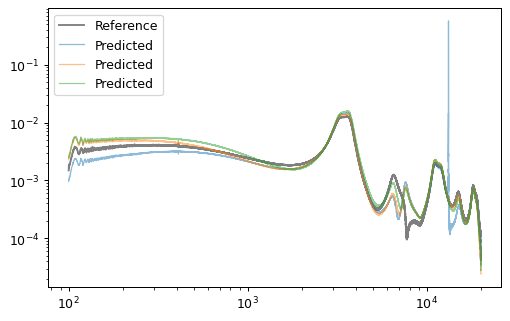

In [24]:
channel = 0
mic1 = 0
N = p_ref.shape[0]
p_probe_pred2 = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

mic1 = 1
# mic2 = 2
p_probe_pred22 = cavern_model.p_measured(
    f[0, 0] * units.Hz, 
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)
    # x_mic[mic1], x_mic[mic2],
    # p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic2] * cal2[:, mic2] * amp_cal)

mic1 = 2
p_probe_pred23 = cavern_model.p_measured(
    f[0, 0] * units.Hz, 
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

plt.figure(**figkwargs)
plt.loglog(f_ref[0, 0], np.abs(p_ref[channel, trial]).T, 'k', alpha=0.5, label='Reference')
# plt.loglog(f[0, 0], np.abs(p_ref_on_f[channel, trial]).T, 'r-', alpha=1, lw=0.2, label='Reference')
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred2[channel]).T, 'C0', alpha=0.5, label="Predicted", lw=1)
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred22[channel]).T, 'C1', alpha=0.5, label="Predicted", lw=1)
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred23[channel]).T, 'C2', alpha=0.5, label="Predicted", lw=1)
plt.legend()

(-30.0, 30.0)

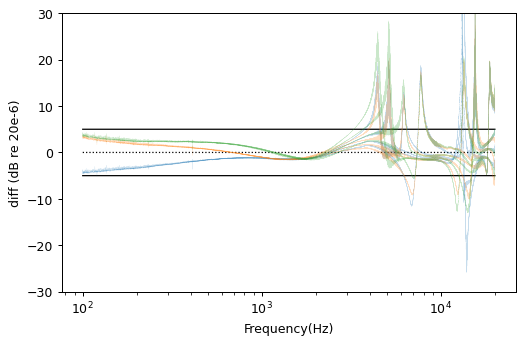

In [25]:
plt.figure(**figkwargs)
plt.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), 'C1', alpha=0.25, lw=0.2)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# Linear x-scale version
# plt.plot(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.plot(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), 'C1', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# This is the same thing
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred2) / p_ref[:, 0]).T, 'C0', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred22) / p_ref[:, 0]).T, 'C1', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred23) / p_ref[:, 0]).T, 'C2', alpha=0.25, lw=0.2)
plt.ylabel('diff (dB re 20e-6)')
plt.xlabel('Frequency(Hz)')
plt.ylim([-30, 30])

(100, 20000)

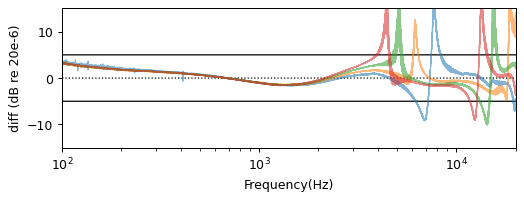

In [26]:
myfigkwars = figkwargs.copy()
myfigkwars['figsize'] = (6.5, 6.5/1.618034 / 2)
plt.figure(**myfigkwars)
plt.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.semilogx(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), alpha=0.55, lw=1)
# plt.semilogx(f_ref[0, 0], todB(p[:N, trial, 1] * cal2[:, 1] * amp_cal).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# Linear x-scale version
# plt.plot(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.plot(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), 'C1', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# This is the same thing
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred2) / p_ref[:, 0]).T, 'C0', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred22) / p_ref[:, 0]).T, 'C1', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred23) / p_ref[:, 0]).T, 'C2', alpha=0.25, lw=0.2)
plt.ylabel('diff (dB re 20e-6)')
plt.xlabel('Frequency(Hz)')
plt.ylim([-15, 15])
plt.xlim([100, 20000])